In [54]:
import pandas as pd
import numpy as np
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
## datos
data= r"C:\Users\REPO\Tec2025\Multivariados\Etapa1\Sureste Crudos.csv"
df_datos_crudos = pd.read_csv(data)
df_datos_crudos.head(5)

,date,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
0,1/1/2020 0:00,NaN,NaN,NaN,NaN,NaN,66.0,54.23,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN
1,1/1/2020 1:00,2.11,NaN,NaN,NaN,19.0,57.0,NaN,735.7,0.0,96.0,5.4,0.01,11.20,8.1,NaN
2,1/1/2020 2:00,2.06,NaN,NaN,NaN,19.0,68.0,53.84,734.8,0.0,96.0,5.5,0.01,11.26,5.5,NaN
3,1/1/2020 3:00,1.96,NaN,NaN,NaN,19.0,68.0,36.47,734.2,0.0,96.0,5.4,0.01,11.35,3.8,NaN
4,1/1/2020 4:00,1.98,NaN,NaN,NaN,16.0,48.0,33.59,733.9,0.0,96.0,5.5,0.01,11.47,3.3,NaN


## Características del Dataset Crudo y Parseo de Fechas a index

In [56]:
from pandas.tseries.frequencies import to_offset

def build_full_grid(
    df,
    dt_col="datetime",
    freq="H",
    date_format=None,   # si conoces el formato exacto ponlo; si no, lo infiere
    dayfirst=False,
    align=False         # si True: start=floor(freq), end=ceil(freq). Por defecto NO alinea.
):
    """
    Crea una malla completa con frecuencia `freq` entre el primer y último timestamp.
    NO agrega filas de más: usa exactamente min(df) y max(df) como límites, a menos que align=True.

    Devuelve:
      df_full: df reindexado a la malla
      report:  dict con info útil (filas originales, esperadas, duplicados, etc.)
    """
    if dt_col not in df.columns:
        # Toma la primera columna si no se especifica
        first_col = df.columns[0]
        dt_col = first_col

    # Parse seguro
    s = df[dt_col].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
    if date_format:
        dt = pd.to_datetime(s, format=date_format, errors="coerce")
    else:
        dt = pd.to_datetime(s, errors="coerce", dayfirst=dayfirst)

    if dt.isna().all():
        raise ValueError("No se pudo parsear la columna de fecha-hora.")

    # Limpieza básica
    out = df.copy()
    out.insert(0, "_dt_", dt)
    out = out.dropna(subset=["_dt_"]).sort_values("_dt_")

    # Quitar duplicados exactos de timestamp (conserva el primero)
    dup_mask = out["_dt_"].duplicated(keep="first")
    dup_count = int(dup_mask.sum())
    out = out[~dup_mask].copy()

    # Determinar límites
    start_raw = out["_dt_"].min()
    end_raw   = out["_dt_"].max()

    if align:
        off = to_offset(freq)
        start = (start_raw.floor(freq) if hasattr(start_raw, "floor") else start_raw)
        end   = (end_raw.ceil(freq)  if hasattr(end_raw,  "ceil")  else end_raw)
    else:
        # Usar exactamente los límites observados (¡no agrega “una hora extra” por redondeo!)
        start, end = start_raw, end_raw

    # Construir malla
    full_idx = pd.date_range(start=start, end=end, freq=freq)
    original_index = pd.Index(out["_dt_"].values)

    # Reindex
    out = out.set_index("_dt_").reindex(full_idx)
    out.index.name = dt_col

    # Flags útiles
    out["was_missing_timestamp"] = ~out.index.isin(original_index)
    value_cols = [c for c in out.columns if c not in ("was_missing_timestamp",)]
    present_mask = out.index.isin(original_index)
    has_na_present = out.loc[present_mask, value_cols].isna().any(axis=1) if value_cols else pd.Series(False, index=out.index[present_mask])
    out["has_missing_values"] = False
    out.loc[present_mask, "has_missing_values"] = has_na_present.values

    #Valores Nulos
    df = df.replace(["", "NULL", "null", "NaN", "nan"], np.nan)
    faltantes_total = df.isna().sum().sum()

    # Reporte
    report = {
        "rows_original": int(len(original_index)),
        "rows_expected_full": int(len(full_idx)),
        "duplicate_timestamps_dropped": dup_count,
        "missing_timestamps_count": int(out["was_missing_timestamp"].sum()),
        "first_timestamp_used": str(start),
        "last_timestamp_used":  str(end),
        "aligned": bool(align),
        "freq": str(freq),
        "datos_faltantes": int(faltantes_total)
    }
    return out, report


In [57]:
grid_df, rep_grid = build_full_grid(df_datos_crudos)
rep_grid

C:\Users\Maria Paula\AppData\Local\Temp\ipykernel_5720\4097778918.py:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start=start, end=end, freq=freq)


{'rows_original': 48183,
 'rows_expected_full': 48192,
 'duplicate_timestamps_dropped': 0,
 'missing_timestamps_count': 9,
 'first_timestamp_used': '2020-01-01 00:00:00',
 'last_timestamp_used': '2025-06-30 23:00:00',
 'aligned': False,
 'freq': 'H',
 'datos_faltantes': 72343}

In [58]:
grid_df.dtypes

date                      object
CO                       float64
NO                       float64
NO2                      float64
NOX                      float64
O3                       float64
PM10                     float64
PM2.5                    float64
PRS                      float64
RAINF                    float64
RH                       float64
SO2                      float64
SR                       float64
TOUT                     float64
WSR                      float64
WDR                      float64
was_missing_timestamp       bool
has_missing_values          bool
dtype: object

In [59]:
rep_grid

{'rows_original': 48183,
 'rows_expected_full': 48192,
 'duplicate_timestamps_dropped': 0,
 'missing_timestamps_count': 9,
 'first_timestamp_used': '2020-01-01 00:00:00',
 'last_timestamp_used': '2025-06-30 23:00:00',
 'aligned': False,
 'freq': 'H',
 'datos_faltantes': 72343}

## Identificación de Outliers

In [60]:
# CONFIGURACIÓN DE RANGOS

# Rangos del fabricante (errores de medición)
MFG_RANGES = {
    "PM10":  (0, 1000),
    "PM2.5": (0, 1000),
    "O3":    (0, 1000),
    "NO":    (0, 500),
    "NO2":   (0, 500),
    "NOx":   (0, 500),
    "SO2":   (0, 500),
    "CO":    (0, 50),
    "RH":    (0, 100),
    "WS":    (0, 180),
    "TEMP":  (-50, 50),
    "SR":    (0, 1.4),
    "BP":    (49.9, 824),
    "WD":    (0, 360),
    # RAINF: conteo * 0.01; solo validamos que no sea negativo
    "RAINF": (0, None),
}

# Rangos de operación por AÑO (outliers)
OP_RANGES = {
    2020: {"PM10":(0,800),"PM2.5":(0,205.94),"O3":(0,153),"NO":(0,500),"NO2":(0,200),
           "NOx":(0,500),"SO2":(0,200),"CO":(0,20),"RH":(0,100),"WS":(0,75),
           "TEMP":(0,41),"SR":(0,1.0),"BP":(690,750),"WD":(0,360),"RAINF":(0,30)},
    2021: {"PM10":(0,800),"PM2.5":(0,325),"O3":(0,175),"NO":(0,350),"NO2":(0,100),
           "NOx":(0,400),"SO2":(0,300),"CO":(0,10),"RH":(0,100),"WS":(0,40),
           "TEMP":(-6.5,45),"SR":(0,1.0),"BP":(690,740),"WD":(0,360),"RAINF":(0,80)},
    2022: {"PM10":(0,999),"PM2.5":(0,450),"O3":(0,160),"NO":(0,400),"NO2":(0,175),
           "NOx":(0,420),"SO2":(0,200),"CO":(0,10),"RH":(0,100),"WS":(0,35),
           "TEMP":(-5,45),"SR":(0,1.25),"BP":(700,740),"WD":(0,360),"RAINF":(0,25)},
    2023: {"PM10":(0,900),"PM2.5":(0,800),"O3":(0,175),"NO":(0,500),"NO2":(0,175),
           "NOx":(0,500),"SO2":(0,250),"CO":(0,14),"RH":(0,100),"WS":(0,40),
           "TEMP":(0,45),"SR":(0,1.0),"BP":(690,740),"WD":(0,360),"RAINF":(0,70)},
    2024: {"PM10":(0,999),"PM2.5":(0,999),"O3":(0,180),"NO":(0,400),"NO2":(0,130),
           "NOx":(0,500),"SO2":(0,150),"CO":(0,18),"RH":(0,100),"WS":(0,38),
           "TEMP":(-4,45.5),"SR":(0,1.26),"BP":(687.5,740),"WD":(0,360),"RAINF":(0,50)},
    2025: {"PM10":(0,820),"PM2.5":(0,350),"O3":(0,185),"NO":(0,350),"NO2":(0,175),
           "NOx":(0,400),"SO2":(0,405),"CO":(0,10),"RH":(0,100),"WS":(0,40),
           "TEMP":(-4.5,45),"SR":(0,1.2),"BP":(688,740),"WD":(0,360),"RAINF":(0,25)},
}

# Aliases para normalizar nombres de columnas (ajústalos si tu dataset usa otros)
ALIASES = {
    "TOUT": "TEMP",
    "WSR":  "WS",
    "PRS":  "BP",
    "NOX":  "NOx",
    "Rainf": "RAINF",
    "RainF": "RAINF",
}


In [61]:
import pandas as pd
import numpy as np

def _norm_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = [str(c).strip() for c in out.columns]
    out.rename(columns={k: v for k, v in ALIASES.items() if k in out.columns}, inplace=True)
    return out

def _to_num(df: pd.DataFrame, cols) -> pd.DataFrame:
    out = df.copy()
    out.replace({"NULL": np.nan, "NaN": np.nan, "nan": np.nan, "": np.nan}, inplace=True)
    for c in cols:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def _year_op_maps(var: str):
    """Devuelve diccionarios {year: min}, {year: max} para una variable."""
    y2min, y2max = {}, {}
    for y, d in OP_RANGES.items():
        if var in d:
            y2min[y] = d[var][0]
            y2max[y] = d[var][1]
    return y2min, y2max

def check_ranges(df: pd.DataFrame,
                 datetime_col: str = "datetime",
                 year_col: str | None = None,
                 zone_col: str | None = None):
    """
    - Anula (pone NaN) valores fuera de MFG_RANGES (error de fabricante).
    - Genera etiqueta booleana <var>_oper_outlier para outliers por año (OP_RANGES).
    Devuelve: df_flagged, issues_long, summary
    """
    # 1) normalizar columnas
    df = _norm_cols(df)

    # 2) datetime y year
    if datetime_col in df.columns:
        dt = pd.to_datetime(df[datetime_col], errors="coerce", dayfirst=False)
    elif "date" in df.columns:
        dt = pd.to_datetime(df["date"], errors="coerce", dayfirst=False)
    else:
        raise ValueError(f"No encuentro columna '{datetime_col}' ni 'date'")

    out = df.copy()
    out["__datetime__"] = dt

    if year_col and year_col in out.columns:
        years = pd.to_numeric(out[year_col], errors="coerce").astype("Int64")
    else:
        years = out["__datetime__"].dt.year.astype("Int64")
    out["__year__"] = years

    # 3) variables presentes y cast numérico
    vars_presentes = [v for v in MFG_RANGES.keys() if v in out.columns]
    out = _to_num(out, vars_presentes)

    # 4) flags + anulaciones (MFG) y etiquetas (OP)
    for var in vars_presentes:
        val = out[var]
        val_orig = val.copy()  # conservar para issues_long

        # --- fabricante: anular si está fuera de rango
        vmin_mfg, vmax_mfg = MFG_RANGES[var]
        meas_err = pd.Series(False, index=out.index)
        if vmin_mfg is not None:
            meas_err |= val < vmin_mfg
        if vmax_mfg is not None:
            meas_err |= val > vmax_mfg
        out[f"{var}_meas_error"] = meas_err.fillna(False)

        # anular SOLO por fabricante:
        out.loc[out[f"{var}_meas_error"], var] = np.nan

        # --- operación (etiquetar por año; no anular)
        y2min, y2max = _year_op_maps(var)
        op_min = out["__year__"].map(y2min)
        op_max = out["__year__"].map(y2max)

        oper_out = (val_orig < op_min) | (val_orig > op_max)  # compara contra valor original
        oper_out = oper_out & op_min.notna() & op_max.notna()
        out[f"{var}_oper_outlier"] = oper_out.fillna(False)

    # 5) issues en formato largo
    id_cols = ["__datetime__", "__year__"] + ([zone_col] if zone_col and zone_col in out.columns else [])
    long_rows = []
    for var in vars_presentes:
        # manufacturer issues
        mask_mfg = out[f"{var}_meas_error"]
        if mask_mfg.any():
            vmin_mfg, vmax_mfg = MFG_RANGES[var]
            block = pd.concat([
                out.loc[mask_mfg, id_cols],
                pd.Series(var, index=out.index[mask_mfg], name="variable"),
                pd.Series("meas_error", index=out.index[mask_mfg], name="issue_type"),
                df.loc[mask_mfg, var].rename("value") if var in df.columns else out.loc[mask_mfg, var].rename("value"),
            ], axis=1)
            block["min_allowed"] = vmin_mfg
            block["max_allowed"] = vmax_mfg
            long_rows.append(block)

        # operational issues
        mask_op = out[f"{var}_oper_outlier"]
        if mask_op.any():
            y2min, y2max = _year_op_maps(var)
            block = pd.concat([
                out.loc[mask_op, id_cols],
                pd.Series(var, index=out.index[mask_op], name="variable"),
                pd.Series("oper_outlier", index=out.index[mask_op], name="issue_type"),
                df.loc[mask_op, var].rename("value") if var in df.columns else out.loc[mask_op, var].rename("value"),
                out.loc[mask_op, "__year__"].map(y2min).rename("min_allowed"),
                out.loc[mask_op, "__year__"].map(y2max).rename("max_allowed"),
            ], axis=1)
            long_rows.append(block)

    issues_long = (pd.concat(long_rows, ignore_index=True)
                   if long_rows else
                   pd.DataFrame(columns=id_cols + ["variable","issue_type","value","min_allowed","max_allowed"]))

    # 6) resumen
    if not issues_long.empty:
        summary = (issues_long
                   .groupby(["variable","issue_type"])
                   .size()
                   .reset_index(name="count")
                   .sort_values(["variable","issue_type"]))
    else:
        summary = pd.DataFrame(columns=["variable","issue_type","count"])

    # 7) salida
    df_flagged = out.drop(columns=["__year__"]).rename(columns={"__datetime__": "datetime"})
    return df_flagged, issues_long, summary


In [62]:
df_flagged, issues_long, summary = check_ranges(grid_df, datetime_col="date", zone_col="zone")

In [63]:
errores_medicion = (issues_long
                    .query('issue_type == "meas_error"')
                    .rename(columns={'__datetime__':'datetime'}))

valores_atipicos = (issues_long
                    .query('issue_type == "oper_outlier"')
                    .rename(columns={'__datetime__':'datetime'}))

print(issues_long.groupby(['issue_type','variable']).size())


issue_type    variable
meas_error    BP           1
              SR           1
oper_outlier  BP           9
              CO           3
              SR           1
              TEMP        35
dtype: int64


## Funciones para las Visualizaciones

In [64]:
UNITS = {
    "PM10": "µg/m³",
    "PM2.5": "µg/m³",
    "O3": "ppb",
    "SO2": "ppb",
    "NO2": "ppb",
    "CO": "ppm",
    "NO": "ppb",
    "Nox": "ppb",
    "TOUT": "°C",
    "RH": "%",
    "SR": "W/m²",
    "RAINF": "mm",
    "PRS": "hPa",
    "WSR": "m/s",
    "WDR": "° (0–360)"
}

CANDIDATES = ["SO2","RAINF","WSR","WDR"]


In [65]:

# HISTOGRAMAS

def plot_histograms(df, cols=None, bins=30, kde=True, max_cols=4, dropna=True):
    """
    Dibuja histogramas para cada variable numérica (o para 'cols' si se pasa).
    - Trata WDR con binrange=(0,360) y sin KDE.
    - Ignora columnas inexistentes automáticamente.
    """
    if cols is None:
        # Usa todas las numéricas si no se especifica
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        # Filtra por las que existan
        cols = [c for c in cols if c in df.columns]

    if dropna:
        df = df.copy()

    n = len(cols)
    if n == 0:
        print("No hay columnas para graficar.")
        return

    ncols = min(max_cols, n)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.2*ncols, 3.6*nrows))
    axes = np.array(axes).reshape(-1)  # vectoriza para iterar fácil

    for i, col in enumerate(cols):
        ax = axes[i]

        data = df[col].dropna() if dropna else df[col]
        if col == "WDR":
            # Histograma circular “linealizado” 0–360
            sns.histplot(data=data, bins=36, binrange=(0, 360), ax=ax, kde=False, stat="count")
            ax.set_xlim(0, 360)
            ax.set_xticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
        else:
            sns.histplot(data=data, bins=bins, ax=ax, kde=kde, stat="count")

        unit = UNITS.get(col, "")
        ax.set_title(f"{col} {f'({unit})' if unit else ''}", fontsize=11)
        ax.set_xlabel(f"{col} {f'({unit})' if unit else ''}")
        ax.set_ylabel("Frecuencia")

    # Quita ejes vacíos si sobran casillas
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [66]:
# TIME SERIES

def plot_timeseries(df, cols=None, bins=30, kde=True, max_cols=4, dropna=False):
    """
    Grafica series de tiempo (líneas) para cada variable en 'cols' (o todas numéricas).
    - Requiere un índice datetime o una columna de fecha-hora.
    - Mantiene la misma firma que 'plot_histograms'; 'bins' y 'kde' se IGNORAN aquí.

    Lógica de timestamp:
      1) Si el índice ya es DatetimeIndex, lo usa.
      2) Si no, busca una columna de tiempo entre:
         ['timestamp','Timestamp','Fecha','fecha','Date','Datetime','datetime','FechaHora','DateTime'].
         Intenta parseo con "%m/%d/%Y %I:%M:%S %p" (ej. '1/1/2020  12:00:00 AM') y luego parseo flexible.

    dropna=False: no elimina NaN antes de graficar.
    max_cols: columnas por fila en la grilla.
    """

    # --- 1) Determinar el eje de tiempo ---
    if isinstance(df.index, pd.DatetimeIndex):
        time_index = df.index
        df_ts = df.copy()
    else:
        ts_candidates = ["date","Timestamp","Fecha","fecha","Date","Datetime","datetime","FechaHora","DateTime"]
        ts_col = next((c for c in ts_candidates if c in df.columns), None)
        if ts_col is None:
            raise ValueError("No encuentro columna de tiempo. Renombra una a 'timestamp' o agrega su nombre a ts_candidates.")

        # Normaliza dobles espacios y parsea tipo '1/1/2020  12:00:00 AM'
        s = df[ts_col].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
        ts = pd.to_datetime(s, format="%m/%d/%Y %I:%M:%S %p", errors="coerce")
        if ts.isna().all():
            # Intento flexible si el formato exacto no coincide
            ts = pd.to_datetime(s, errors="coerce")
        df_ts = df.copy()
        df_ts["__ts__"] = ts
        df_ts = df_ts.dropna(subset=["__ts__"]).set_index("__ts__")
        time_index = df_ts.index

    # --- 2) Selección de columnas ---
    if cols is None:
        cols = df_ts.select_dtypes(include=[np.number]).columns.tolist()
    else:
        cols = [c for c in cols if c in df_ts.columns]

    if not cols:
        print("No hay columnas para graficar.")
        return

    # --- 3) Preparar grilla ---
    n = len(cols)
    ncols = min(max_cols, n)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5.0*ncols, 3.2*nrows), sharex=True)
    axes = np.array(axes).reshape(-1)

    units_map = globals().get("UNITS", {})  # usa UNITS si ya lo definiste; si no, vacío

    # --- 4) Graficar cada serie ---
    for i, col in enumerate(cols):
        ax = axes[i]
        # Asegura numérico y orden temporal
        ser = pd.to_numeric(df_ts[col], errors="coerce")
        s = ser.dropna()

        if s.empty:
            ax.text(0.5, 0.5, f"Sin datos válidos\nen {col}", ha="center", va="center", transform=ax.transAxes)
            ax.axis("off")
            continue

        s = s.sort_index()

        ax.plot(s.index, s.values, lw=0.8)
        unit = units_map.get(col, "")
        title = f"{col} {f'({unit})' if unit else ''}"
        ax.set_title(title, fontsize=11)
        ax.set_ylabel(f"{col}{f' ({unit})' if unit else ''}")

        # Tratamiento especial para WDR (0–360) si quieres fijar el rango
        if col.upper() == "WDR":
            ax.set_ylim(0, 360)
            ax.set_yticks([0, 90, 180, 270, 360])

    # Apaga ejes sobrantes
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    fig.autofmt_xdate()
    plt.tight_layout()
    

# GRÁFICAS DE DATOS CRUDOS

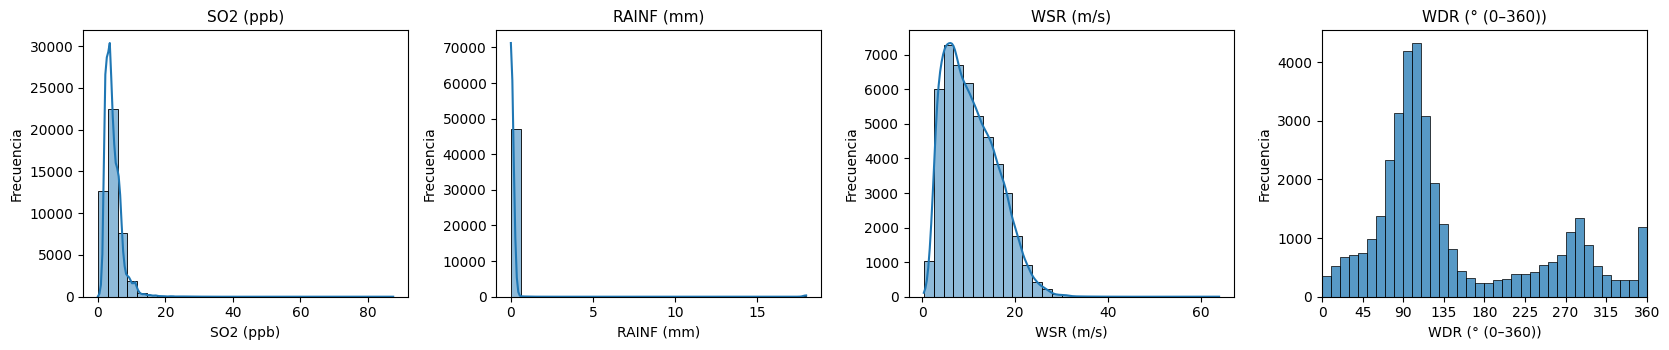

In [67]:
vars_a_graficar = [c for c in CANDIDATES if c in df_datos_crudos.columns]
plot_histograms(grid_df, cols=vars_a_graficar, bins=30, kde=True, max_cols=4)

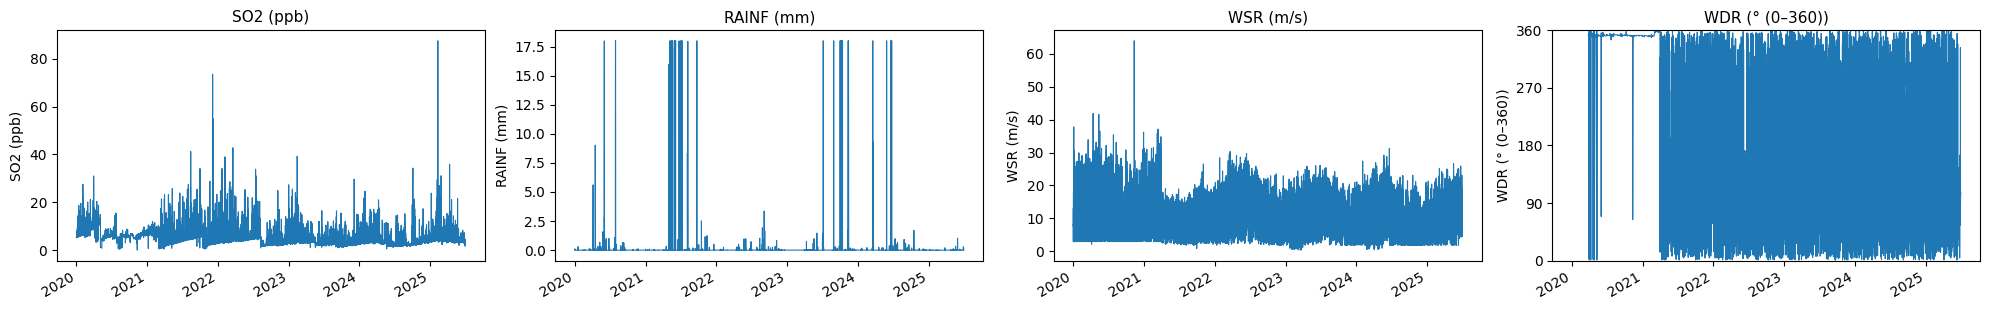

In [68]:
plot_timeseries(grid_df, cols=CANDIDATES)

# Normalizar

In [69]:
class SimpleScaler:
    """
    Normalizador sencillo con dos métodos:
      - 'zscore': (x - mean)/std
      - 'robust': (x - median)/(1.4826*MAD)
    Ignora NaNs al calcular parámetros.
    """
    def __init__(self, method="zscore"):
        assert method in ("zscore", "robust")
        self.method = method
        self.params_ = {}   # col -> (loc, scale)
        self.cols_ = None

    def fit(self, df: pd.DataFrame, cols=None):
        numcols = df.select_dtypes(include=[np.number]).columns.tolist()
        self.cols_ = [c for c in (cols or numcols) if c in df.columns]
        for c in self.cols_:
            x = pd.to_numeric(df[c], errors="coerce")
            if self.method == "zscore":
                loc = np.nanmean(x)
                scale = np.nanstd(x, ddof=1)
            else:  # robust
                loc = np.nanmedian(x)
                mad = np.nanmedian(np.abs(x - loc))
                scale = 1.4826 * mad  # consistente con desviación std bajo normal
            if not np.isfinite(scale) or scale == 0:
                scale = 1.0  # evita división por cero
            self.params_[c] = (float(loc), float(scale))
        return self

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        out = df.copy()
        for c in self.cols_:
            loc, scale = self.params_[c]
            out[c] = (pd.to_numeric(out[c], errors="coerce") - loc) / scale
        return out

    def inverse_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        out = df.copy()
        for c in self.cols_:
            loc, scale = self.params_[c]
            out[c] = pd.to_numeric(out[c], errors="coerce") * scale + loc
        return out

    def fit_transform(self, df: pd.DataFrame, cols=None) -> pd.DataFrame:
        return self.fit(df, cols=cols).transform(df)


def normalize_df(df: pd.DataFrame, method="robust", exclude=("WDR",), cols=None):
    """
    Devuelve df_normalizado (solo numéricas/cols salvo exclude) y el scaler para revertir.
    """
    numcols = df.select_dtypes(include=[np.number]).columns.tolist()
    target_cols = [c for c in (cols or numcols) if c not in exclude]
    scaler = SimpleScaler(method=method).fit(df, cols=target_cols)
    df_scaled = scaler.transform(df)
    return df_scaled, scaler

In [70]:
df_scaled, scaler = normalize_df(grid_df)

# Funciones para Imputar Datos
Algoritmo ME

In [71]:
def _symmetrize(a):
    return 0.5 * (a + a.T)

def em_impute_mvn(df: pd.DataFrame,
                  cols=None,
                  max_iter=100,
                  tol=1e-4,
                  reg=1e-6,
                  verbose=False):
    """
    EM para imputación asumiendo Normal Multivariada.
    - df: DataFrame con NaNs en columnas numéricas
    - cols: columnas a imputar (por defecto: numéricas)
    - reg: regularización diagonal para invertir submatrices (estabilidad)
    Retorna: (df_imputado, info_dict)
    """
    # 1) Selección de columnas y matriz X
    numcols = df.select_dtypes(include=[np.number]).columns.tolist()
    cols = [c for c in (cols or numcols) if c in df.columns]
    if len(cols) == 0:
        return df.copy(), {"converged": True, "n_iter": 0, "mu": None, "Sigma": None, "cols": []}

    X = df[cols].astype(float).to_numpy()
    n, p = X.shape
    mask = np.isnan(X)

    # 2) Inicialización con medias por columna
    mu = np.nanmean(X, axis=0)
    X_init = np.where(mask, mu, X)
    # np.cov usa columnas como variables con rowvar=False
    Sigma = np.cov(np.nan_to_num(X_init, nan=np.nanmean(X_init, axis=0)), rowvar=False, ddof=1)
    if Sigma.shape == ():
        Sigma = np.array([[float(Sigma)]])
    if not np.all(np.isfinite(Sigma)):
        Sigma = np.eye(p)

    Sigma = _symmetrize(Sigma) + reg * np.eye(p)

    def _solve_inv(A):
        # inversa estable con pequeña regularización
        return np.linalg.pinv(A)

    # 3) Iteraciones EM
    for it in range(1, max_iter + 1):
        S1 = np.zeros(p)            # suma de E[x]
        S2 = np.zeros((p, p))       # suma de E[xx^T]

        # E-step: expectativas por fila
        for i in range(n):
            obs = ~mask[i]
            mis = mask[i]
            if not np.any(mis):  # fila completa
                xi = X[i]
                S1 += xi
                S2 += np.outer(xi, xi)
                continue

            # Si todo es missing: usar mu y + cov
            if not np.any(obs):
                x_hat = mu.copy()
                S1 += x_hat
                S2 += np.outer(x_hat, x_hat) + Sigma
                continue

            x_o = X[i, obs]
            mu_o = mu[obs]
            mu_m = mu[mis]

            Sigma_oo = Sigma[np.ix_(obs, obs)]
            Sigma_mo = Sigma[np.ix_(mis, obs)]
            Sigma_om = Sigma_mo.T
            Sigma_mm = Sigma[np.ix_(mis, mis)]

            inv_Sigma_oo = _solve_inv(Sigma_oo + reg * np.eye(Sigma_oo.shape[0]))

            # E[x_m | x_o]
            cond_mean_m = mu_m + Sigma_mo @ inv_Sigma_oo @ (x_o - mu_o)

            # E[(x_m - mu_m)(x_m - mu_m)^T | x_o]
            cond_cov_mm = Sigma_mm - Sigma_mo @ inv_Sigma_oo @ Sigma_om
            # Reconstruye E[x] = x_hat
            x_hat = np.empty(p)
            x_hat[obs] = x_o
            x_hat[mis] = cond_mean_m

            # E[xx^T] = x_hat x_hat^T + "extra" en bloque mm por var condicional
            S1 += x_hat
            S2 += np.outer(x_hat, x_hat)
            S2[np.ix_(mis, mis)] += cond_cov_mm

        # M-step
        mu_new = S1 / n
        Sigma_new = S2 / n - np.outer(mu_new, mu_new)
        Sigma_new = _symmetrize(Sigma_new) + reg * np.eye(p)

        # Criterio de convergencia: cambio en parámetros
        d_mu = np.linalg.norm(mu_new - mu, ord=np.inf)
        d_S = np.linalg.norm(Sigma_new - Sigma, ord='fro') / (1 + np.linalg.norm(Sigma, ord='fro'))

        if verbose:
            print(f"[EM] iter {it} | d_mu={d_mu:.3e} d_S={d_S:.3e}")

        mu, Sigma = mu_new, Sigma_new
        if max(d_mu, d_S) < tol:
            break

    # 4) Construir imputación final con medias condicionales
    X_imp = X.copy()
    for i in range(n):
        mis = mask[i]
        if not np.any(mis):
            continue
        obs = ~mis
        if not np.any(obs):
            X_imp[i, :] = mu
            continue
        x_o = X[i, obs]
        mu_o = mu[obs]
        mu_m = mu[mis]
        Sigma_oo = Sigma[np.ix_(obs, obs)]
        Sigma_mo = Sigma[np.ix_(mis, obs)]
        inv_Sigma_oo = np.linalg.pinv(Sigma_oo + reg * np.eye(Sigma_oo.shape[0]))
        cond_mean_m = mu_m + Sigma_mo @ inv_Sigma_oo @ (x_o - mu_o)
        X_imp[i, mis] = cond_mean_m

    df_out = df.copy()
    df_out[cols] = X_imp

    info = {
        "converged": (it < max_iter),
        "n_iter": it,
        "mu": mu,
        "Sigma": Sigma,
        "cols": cols,
    }
    return df_out, info

In [72]:
df_imputado, info = em_impute_mvn(
    df_scaled,        # o "robust" si hay outliers fuertes
    max_iter=200,
    tol=1e-5,
    verbose=True
)


[EM] iter 1 | d_mu=2.706e-01 d_S=2.222e-01
[EM] iter 2 | d_mu=5.229e-02 d_S=4.158e-02
[EM] iter 3 | d_mu=6.755e-02 d_S=9.682e-03
[EM] iter 4 | d_mu=6.317e-02 d_S=2.542e-03
[EM] iter 5 | d_mu=4.521e-02 d_S=8.952e-04
[EM] iter 6 | d_mu=2.880e-02 d_S=5.534e-04
[EM] iter 7 | d_mu=1.748e-02 d_S=4.572e-04
[EM] iter 8 | d_mu=1.073e-02 d_S=4.017e-04
[EM] iter 9 | d_mu=6.784e-03 d_S=3.585e-04
[EM] iter 10 | d_mu=4.414e-03 d_S=3.222e-04
[EM] iter 11 | d_mu=4.970e-03 d_S=2.909e-04
[EM] iter 12 | d_mu=5.269e-03 d_S=2.634e-04
[EM] iter 13 | d_mu=5.313e-03 d_S=2.391e-04
[EM] iter 14 | d_mu=5.195e-03 d_S=2.174e-04
[EM] iter 15 | d_mu=4.980e-03 d_S=1.979e-04
[EM] iter 16 | d_mu=4.709e-03 d_S=1.804e-04
[EM] iter 17 | d_mu=4.411e-03 d_S=1.644e-04
[EM] iter 18 | d_mu=4.104e-03 d_S=1.500e-04
[EM] iter 19 | d_mu=3.800e-03 d_S=1.369e-04
[EM] iter 20 | d_mu=3.506e-03 d_S=1.249e-04
[EM] iter 21 | d_mu=3.227e-03 d_S=1.141e-04
[EM] iter 22 | d_mu=2.964e-03 d_S=1.042e-04
[EM] iter 23 | d_mu=2.718e-03 d_S=9.511e-

In [73]:
import pandas as pd
import numpy as np

# REPORTE DE DATOS FALTANTES
def missing_report_by_year(df, datetime_col="date"):
    """
    Devuelve un DataFrame con el conteo de valores faltantes por variable y por año.
    """
    if df.index.name != datetime_col or not np.issubdtype(df.index.dtype, np.datetime64):
        df = df.copy()
        df[datetime_col] = pd.to_datetime(df[datetime_col], errors="coerce")
        df = df.set_index(datetime_col).sort_index()

    report = df.isna().groupby(df.index.year).sum()
    return report



In [74]:
# CANTIDAD DE NAS POR AÑO POR VARIABLE
report = missing_report_by_year(df_imputado)

In [75]:
report[['SO2', 'RAINF', 'WSR', 'WDR']]

,SO2,RAINF,WSR,WDR
date,,,,
2020,0,0,0,0
2021,0,0,0,0
2022,0,0,0,0
2023,0,0,0,0
2024,0,0,0,0
2025,0,0,0,0


# comparación de na antes y después de la imputación simple

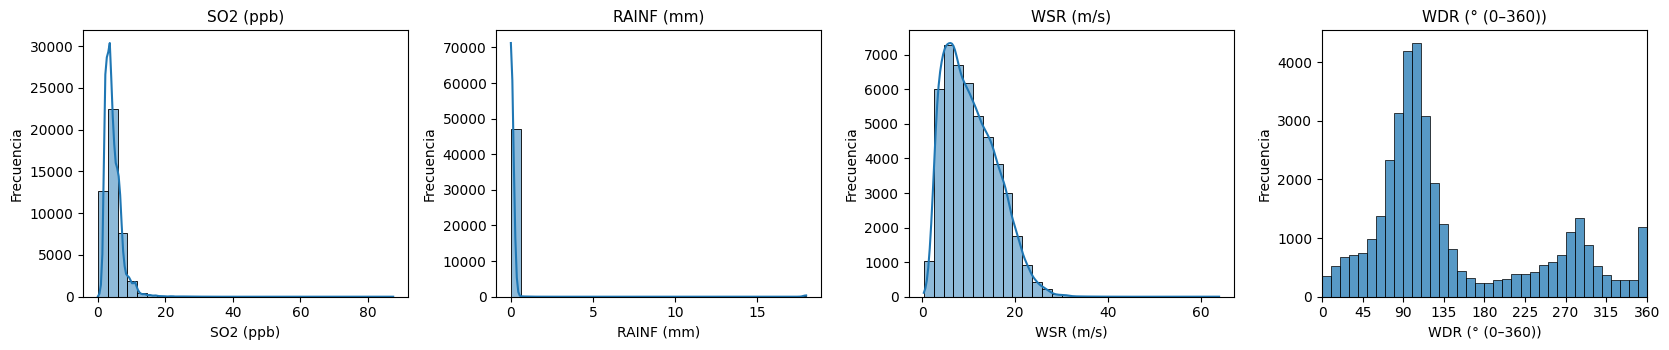

In [76]:
# histogramas de datos SIN IMPUTAR
plot_histograms(grid_df, cols=vars_a_graficar, bins=30, kde=True, max_cols=4)

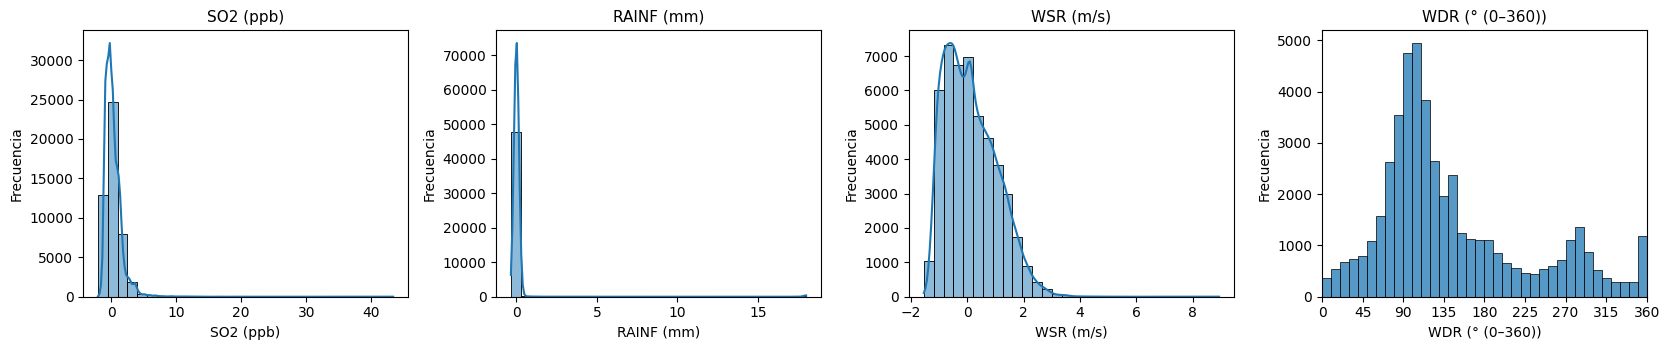

In [77]:
# histogramas de datos imputados todos
plot_histograms(df_imputado, cols=vars_a_graficar, bins=30, kde=True, max_cols=4)

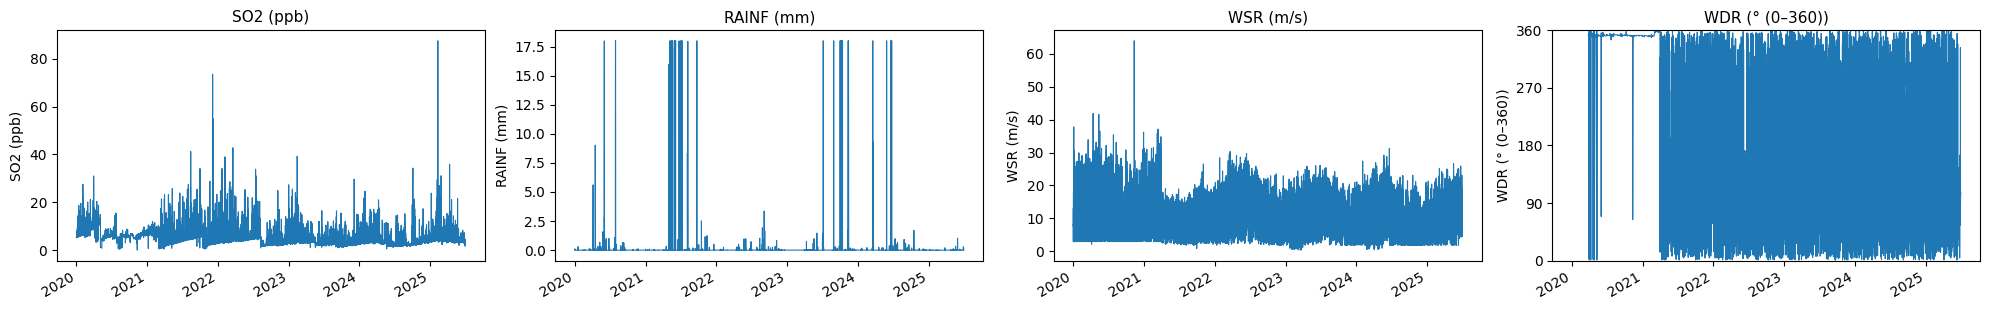

In [78]:
plot_timeseries(grid_df, cols=CANDIDATES)

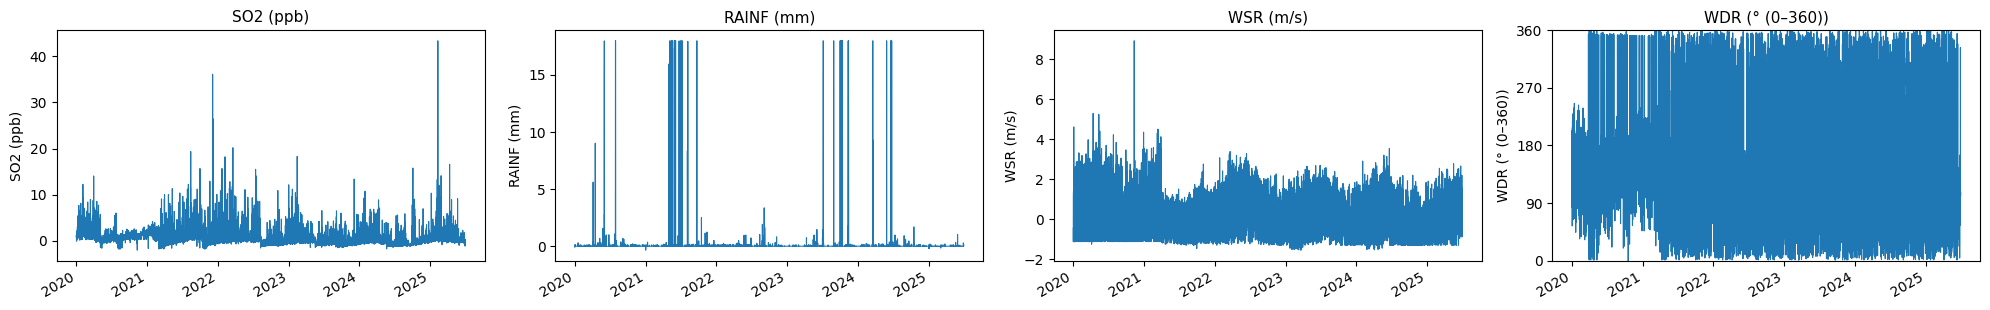

In [79]:
plot_timeseries(df_imputado, cols=CANDIDATES)

## Escalar Datos

In [80]:
# no se le aplicará robust scales a WDR porque no son coordenadas
from sklearn.preprocessing import RobustScaler
def robust_scaler(df, exclude_cols=("WDR",)):
    """
    Devuelve:
        - df_scaled: DataFrame con columnas escaladas
        - scaler: objeto RobustScaler entrenado (útil para transformar nuevos datos)
    """
    out = df.copy()

    # columnas numéricas (float/int) que no están excluidas
    num_cols = out.select_dtypes(include=[np.number]).columns
    cols_to_scale = [c for c in num_cols if c not in exclude_cols]

    scaler = RobustScaler()
    out[cols_to_scale] = scaler.fit_transform(out[cols_to_scale])

    return out, scaler

In [81]:
df_scaled, scaler = robust_scaler(df_imputado, exclude_cols=["WDR"])

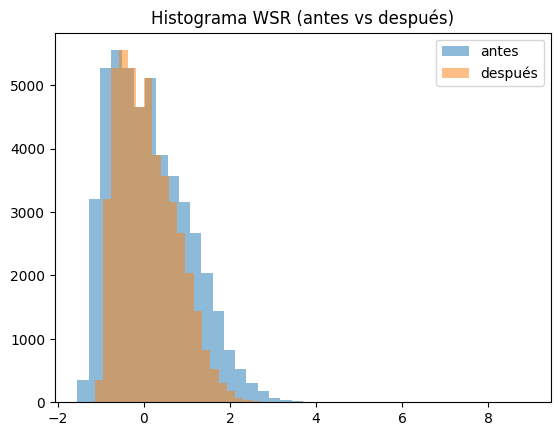

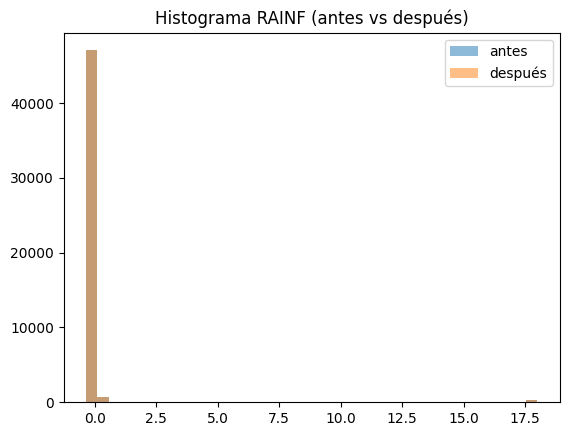

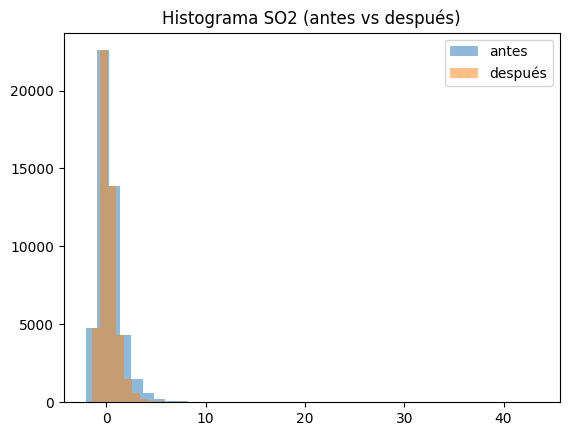

In [82]:
# histogramas de datos imputados y escalados
vars_a_graficar = ["WSR", "RAINF", "SO2"] 

for col in vars_a_graficar:
    before = pd.to_numeric(df_imputado[col], errors="coerce").dropna()
    after  = df_scaled[col].dropna()

    plt.figure()
    plt.hist(before, bins=40, alpha=0.5, label="antes")
    plt.hist(after,  bins=40, alpha=0.5, label="después")
    plt.legend()
    plt.title(f"Histograma {col} (antes vs después)")
    plt.show()


## Base de datos Final 
Imputada y escalada, no se utilizarán los datos del 2020 porque por la forma en la que se hace la imputación no se pueden eliminar datos na

In [83]:
df_final = df_scaled.loc[~(df_scaled.index.year == 2020)]
df_final = df_final[['SO2', 'RAINF', 'WSR', 'WDR']]
df_final

,SO2,RAINF,WSR,WDR
date,,,,
2021-01-01 00:00:00,0.851852,-0.343066,-0.385542,186.894054
2021-01-01 01:00:00,0.925926,0.000000,0.530120,150.813047
2021-01-01 02:00:00,0.851852,0.000000,0.204819,152.774663
2021-01-01 03:00:00,0.814815,0.000000,-0.385542,169.707344
2021-01-01 04:00:00,0.851852,0.000000,-0.277108,165.966158
...,...,...,...,...
2025-06-30 19:00:00,-0.740741,0.010000,0.674699,106.000000
2025-06-30 20:00:00,-0.703704,0.000000,0.867470,101.000000
2025-06-30 21:00:00,-0.777778,0.160000,0.734940,108.000000


In [84]:
df_final.to_csv('DF_FINAL_SURESTE.csv')